In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-emotion-recognition-en/Savee/JE_h09.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_f12.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_h03.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_d04.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_a14.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JE_f01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_h15.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_su02.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_a06.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_n01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_f01.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JK_n22.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_a10.wav
/kaggle/input/speech-emotion-recognition-en/Savee/JE_n08.wav
/kaggle/input/speech-emotion-recognition-en/Savee/KL_sa13.wav
/kaggle/input/speech-emotion-recognition-en/Savee/DC_a12.wav
/kaggle/input/speech-e

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Getting Dataset

In [3]:
crema_path = '/kaggle/input/speech-emotion-recognition-en/Crema/'
ravdess_path = '/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
savee_path = '/kaggle/input/speech-emotion-recognition-en/Savee/'
tess_path = '/kaggle/input/speech-emotion-recognition-en/Tess/'

## Data Analysis

In [4]:
crema = []

for wav in os.listdir(crema_path):
    emotion = wav.partition('.wav')[0].split('_')
    if emotion[2] == 'SAD':
        crema.append(('sad', crema_path + '/' + wav))
    elif emotion[2] == 'ANG':
        crema.append(('angry', crema_path + '/' + wav))
    elif emotion[2] == 'DIS':
        crema.append(('disgust', crema_path + '/' + wav))
    elif emotion[2] == 'FEA':
        crema.append(('fear', crema_path + '/' + wav))
    elif emotion[2] == 'HAP':
        crema.append(('happy', crema_path + '/' + wav))
    elif emotion[2] == 'NEU':
        crema.append(('neutral', crema_path + '/' + wav))
    else:
        crema.append(('unknown', crema_path + '/' + wav))

crema_df = pd.DataFrame.from_dict(crema)
crema_df.rename(columns = {0: 'Emotion', 1: 'File_Path'}, inplace = True)

crema_df.head()

Emotion                                          File_Path
0  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
1    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
2    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
3  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
4  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...

In [5]:
crema_df['Emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [6]:
ravdess=[]

for directory in os.listdir(ravdess_path):
    actors = os.listdir(os.path.join(ravdess_path, directory))
    for wav in actors:
        emotion = wav.partition('.wav')[0].split('-')
        emotion_number = int(emotion[2])
        ravdess.append((emotion_number, os.path.join(ravdess_path, directory, wav)))
        
ravdess_df = pd.DataFrame.from_dict(ravdess)
ravdess_df.rename(columns = {0: 'Emotion',1: 'File_Path'}, inplace = True)
ravdess_df['Emotion'].replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace = True)

ravdess_df.head()

Emotion                                          File_Path
0  surprise  /kaggle/input/speech-emotion-recognition-en/Ra...
1   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...
2   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
3   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
4   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...

In [7]:
ravdess_df['Emotion'].unique()

array(['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'],
      dtype=object)

In [8]:
savee=[]

for wav in os.listdir(savee_path):
    emo = wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion = re.split(r'[0-9]',emo)[0]
    if emotion == 'a':
        savee.append(('angry', savee_path + '/' + wav))
    elif emotion == 'd':
        savee.append(('disgust', savee_path + '/' + wav))
    elif emotion == 'f':
        savee.append(('fear', savee_path +'/' + wav))
    elif emotion == 'h':
        savee.append(('happy', savee_path + '/' + wav))
    elif emotion == 'n':
        savee.append(('neutral', savee_path + '/' + wav))
    elif emotion == 'sa':
        savee.append(('sad', savee_path + '/' + wav))
    elif emotion == 'su':
        savee.append(('surprise', savee_path + '/' + wav))
        
savee_df = pd.DataFrame.from_dict(savee)
savee_df.rename(columns = {0: 'Emotion', 1: 'File_Path'}, inplace = True)

savee_df.head()


Emotion                                          File_Path
0    happy  /kaggle/input/speech-emotion-recognition-en/Sa...
1     fear  /kaggle/input/speech-emotion-recognition-en/Sa...
2    happy  /kaggle/input/speech-emotion-recognition-en/Sa...
3  disgust  /kaggle/input/speech-emotion-recognition-en/Sa...
4    angry  /kaggle/input/speech-emotion-recognition-en/Sa...

In [9]:
savee_df['Emotion'].unique()

array(['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad'],
      dtype=object)

In [10]:
tess=[]

for directory in os.listdir(tess_path):
    for wav in os.listdir(os.path.join(tess_path, directory)):
        emotion = wav.partition('.wav')[0].split('_')
        if emotion[2] == 'ps':
            tess.append(('surprise', os.path.join(tess_path, directory, wav)))
        else:
            tess.append((emotion[2], os.path.join(tess_path, directory, wav)))
            
tess_df = pd.DataFrame.from_dict(tess)
tess_df.rename(columns = {0: 'Emotion',1: 'File_Path'}, inplace = True)

tess_df.head()

Emotion                                          File_Path
0    fear  /kaggle/input/speech-emotion-recognition-en/Te...
1    fear  /kaggle/input/speech-emotion-recognition-en/Te...
2    fear  /kaggle/input/speech-emotion-recognition-en/Te...
3    fear  /kaggle/input/speech-emotion-recognition-en/Te...
4    fear  /kaggle/input/speech-emotion-recognition-en/Te...

In [11]:
tess_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [12]:
main_df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
main_df.shape

(12162, 2)

In [13]:
main_df.head()

Emotion                                          File_Path
0  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
1    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
2    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
3  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
4  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...

In [14]:
main_df.tail()

Emotion                                          File_Path
2795  surprise  /kaggle/input/speech-emotion-recognition-en/Te...
2796  surprise  /kaggle/input/speech-emotion-recognition-en/Te...
2797  surprise  /kaggle/input/speech-emotion-recognition-en/Te...
2798  surprise  /kaggle/input/speech-emotion-recognition-en/Te...
2799  surprise  /kaggle/input/speech-emotion-recognition-en/Te...

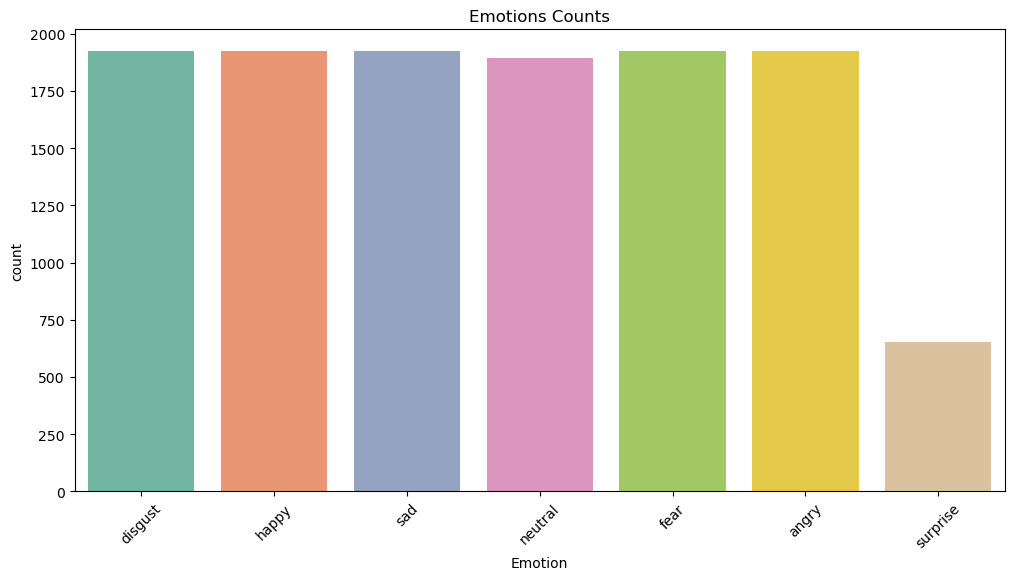

In [15]:
plt.figure(figsize = (12, 6))
plt.title('Emotions Counts')
emotions = sns.countplot(x = 'Emotion', data = main_df, palette = 'Set2')
emotions.set_xticklabels(emotions.get_xticklabels(), rotation = 45)
plt.show()

In [16]:
emotion_names = main_df['Emotion'].unique()

In [17]:
colors = {'disgust': '#804E2D','happy': '#F19C0E','sad': '#478FB8','neutral': '#4CB847','fear': '#7D55AA','angry': '#C00808','surprise': '#EE00FF'}

In [18]:
def wave_plot(data, sr, emotion, color):
    plt.figure(figsize = (12, 5))
    plt.title(f'{emotion} emotion for waveplot', size = 17)
    librosa.display.waveshow(y = data, sr = sr, color = color)

In [19]:
def spectogram(data, dr, emotion):
    audio = librosa.stft(data)
    audio_db = librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize = (12, 5))
    plt.title(f'{emotion} emotion for spectogram', size = 17)
    librosa.display.specshow(audio_db, sr = sr, x_axis = 'time', y_axis = 'hz')

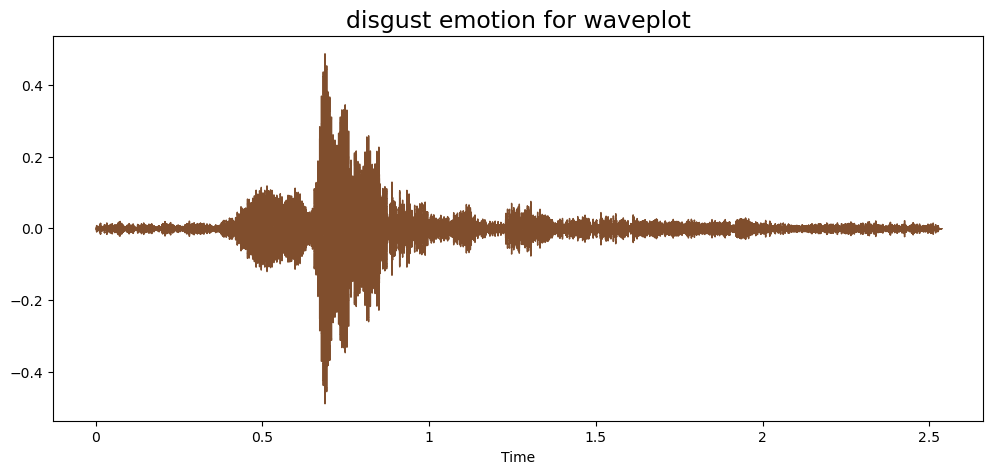

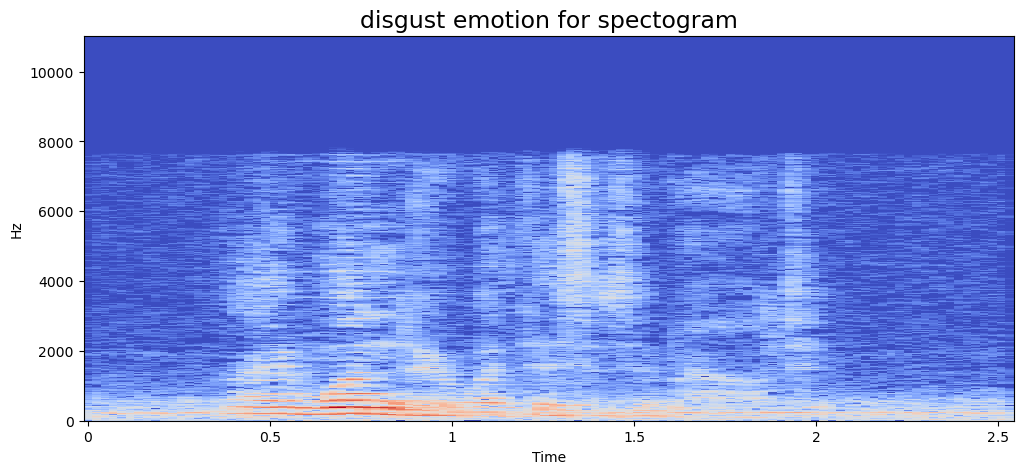

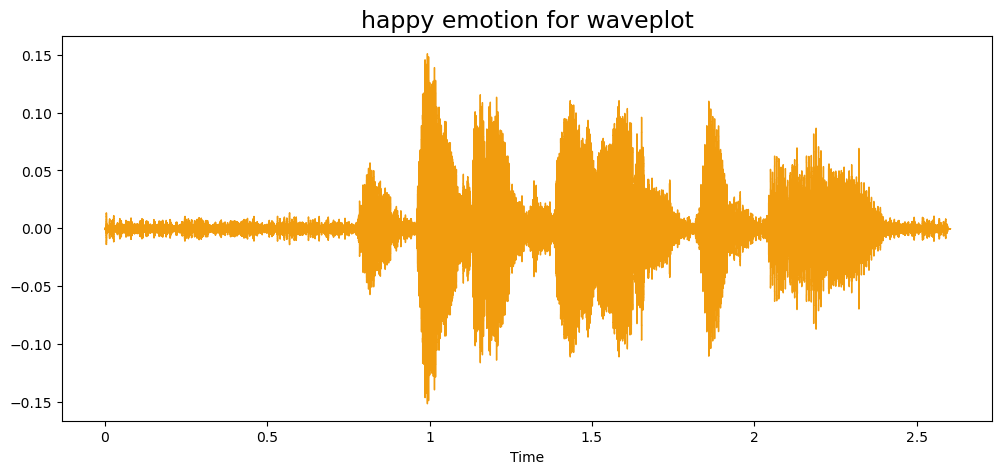

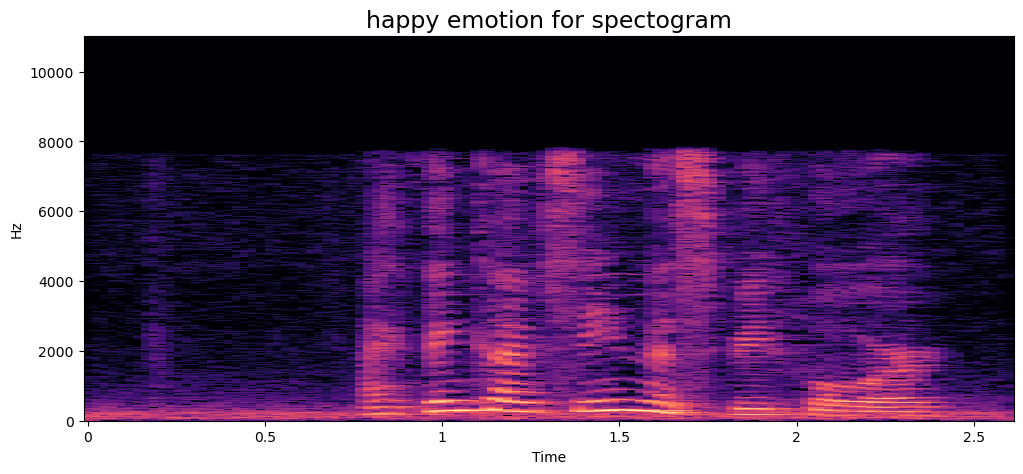

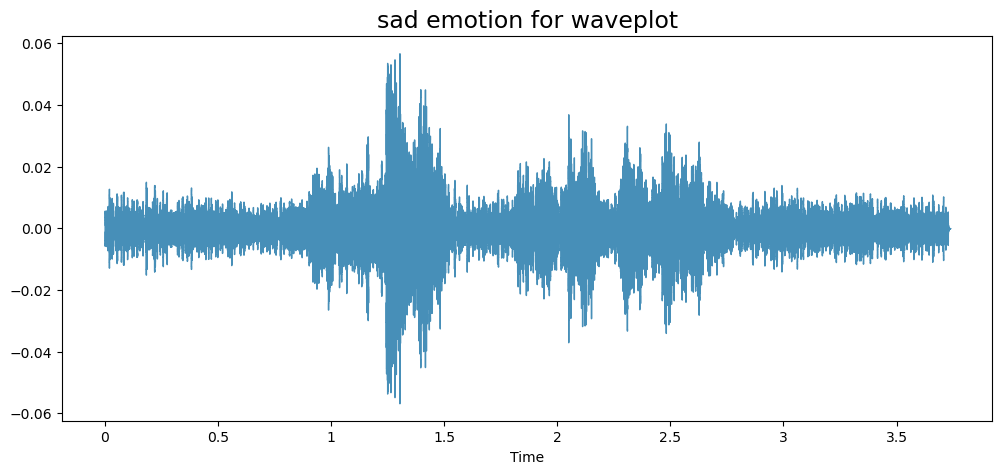

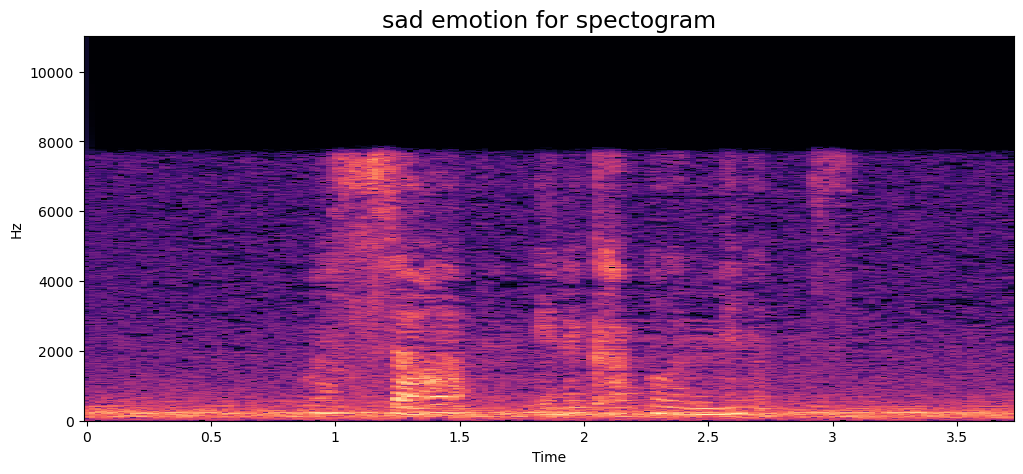

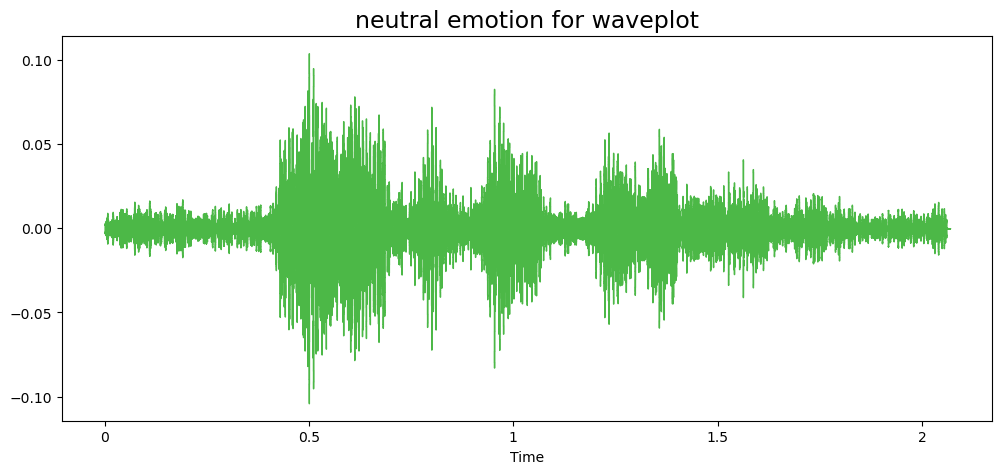

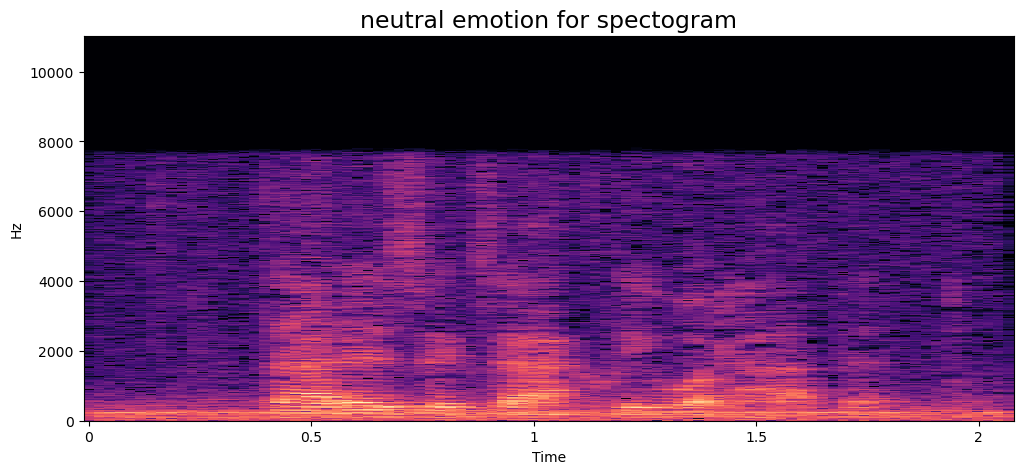

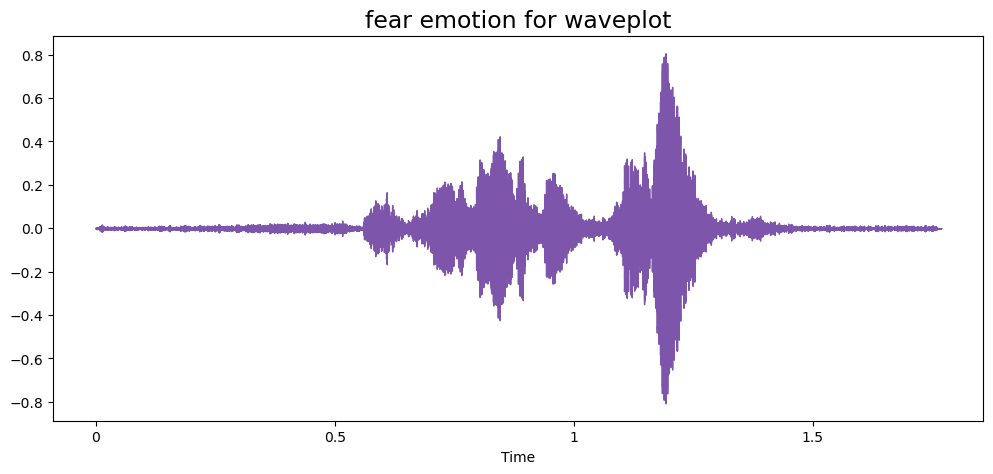

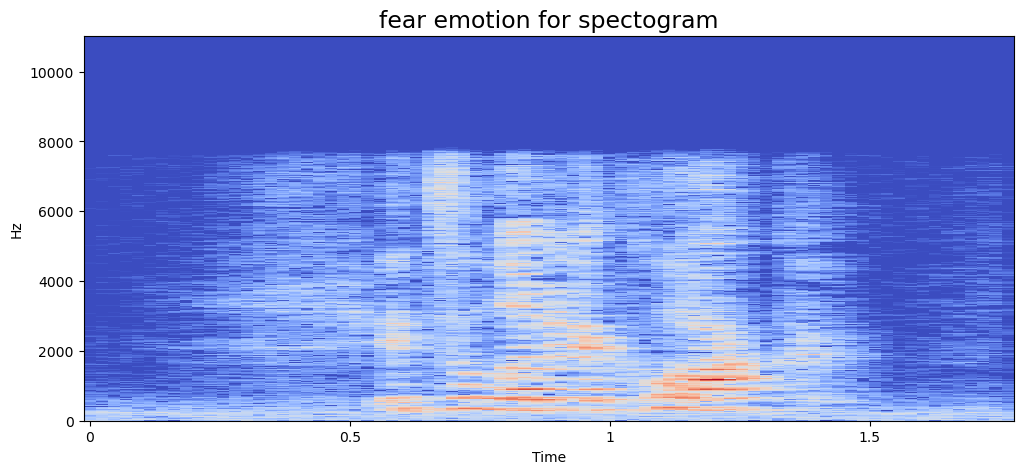

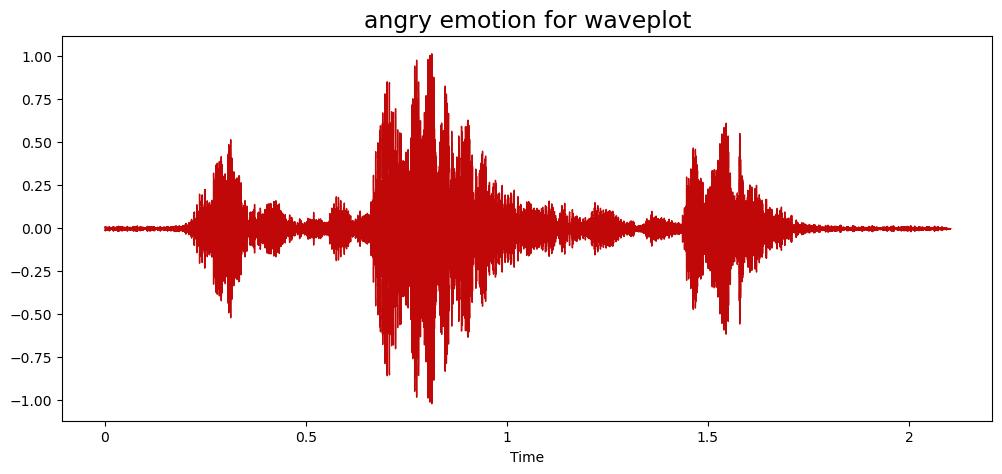

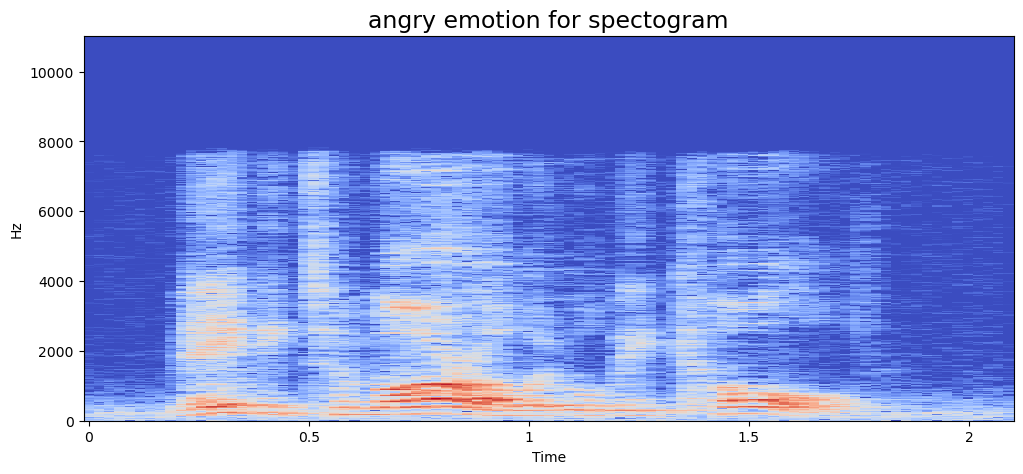

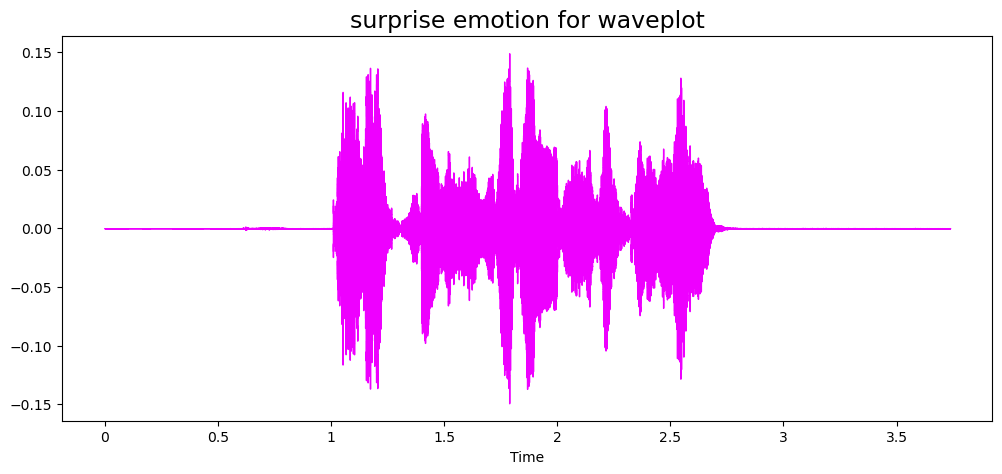

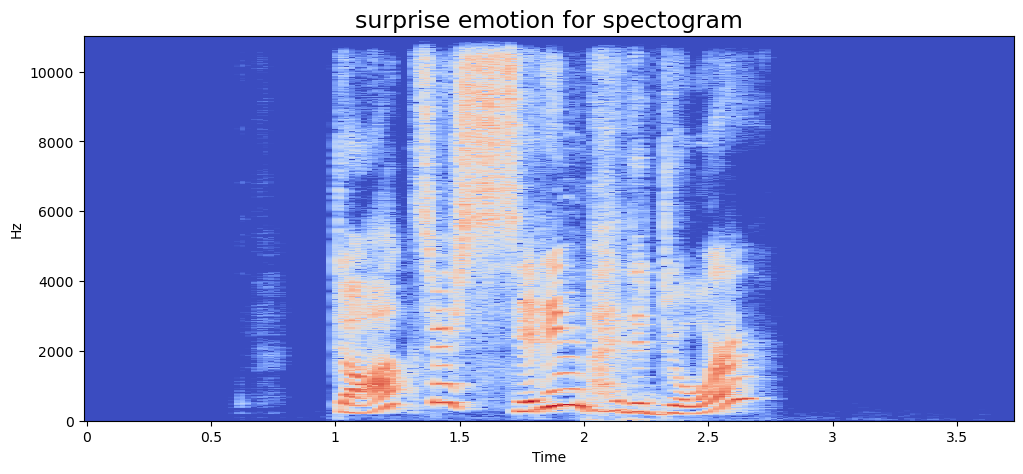

In [20]:
audio_path = []

for emotion in emotion_names:
    path = np.array(main_df['File_Path'][main_df['Emotion'] == emotion])[1]
    data, sr = librosa.load(path)
    wave_plot(data, sr, emotion, colors[emotion])
    spectogram(data, sr, emotion)
    audio_path.append(path)

In [21]:
print('Disgust Audio Sample\n')
IPython.display.Audio(audio_path[0])

Disgust Audio Sample



In [22]:
print('Happy Audio Sample\n')
IPython.display.Audio(audio_path[1])

Happy Audio Sample



In [23]:
print('Sad Audio Sample\n')
IPython.display.Audio(audio_path[2])

Sad Audio Sample



In [24]:
print('Neutral Audio Sample\n')
IPython.display.Audio(audio_path[3])

Neutral Audio Sample



In [25]:
print('Fear Audio Sample\n')
IPython.display.Audio(audio_path[4])

Fear Audio Sample



In [26]:
print('Angry Audio Sample\n')
IPython.display.Audio(audio_path[5])

Angry Audio Sample



In [27]:
print('Surprise Audio Sample\n')
IPython.display.Audio(audio_path[6])

Surprise Audio Sample



## Audio Augmentation

In [28]:
def add_noise(data, random = False, rate = 0.035, threshold = 0.075):
    if random:
        rate = np.random.random() * threshold
    noise = rate * np.random.uniform() * np.amax(data)
    augmented_data = data + noise * np.random.normal(size = data.shape[0])
    return augmented_data

def shifting(data, rate = 1000):
    augmented_data = int(np.random.uniform(low = -5, high = 5) * rate)
    augmented_data = np.roll(data, augmented_data)
    return augmented_data

def pitching(data, sr, pitch_factor = 0.7, random = False):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr = sr, n_steps = pitch_factor)

def stretching(data, rate = 0.8):
    return librosa.effects.time_stretch(data, rate = rate)

In [29]:
data, sr = librosa.load(audio_path[6])

### Original Audio

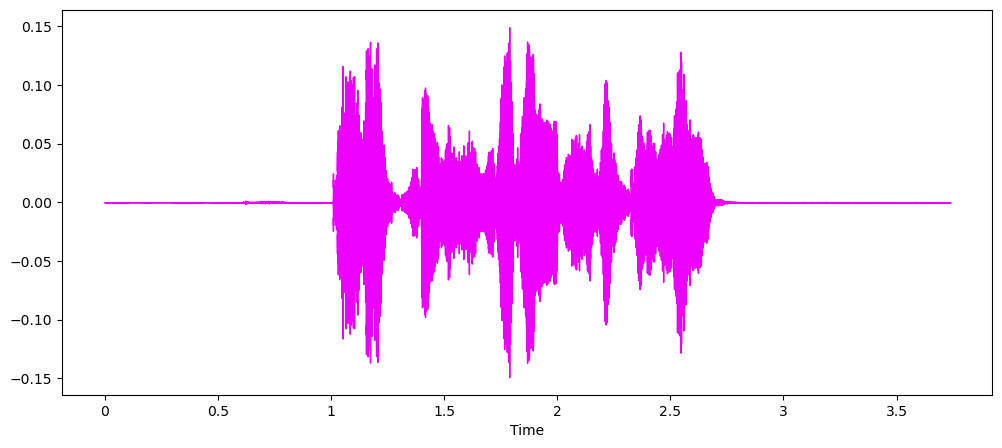

In [30]:
plt.figure(figsize = (12,5))
librosa.display.waveshow(y = data,sr = sr,color = '#EE00FF')
IPython.display.Audio(audio_path[6])

### Noised Audio

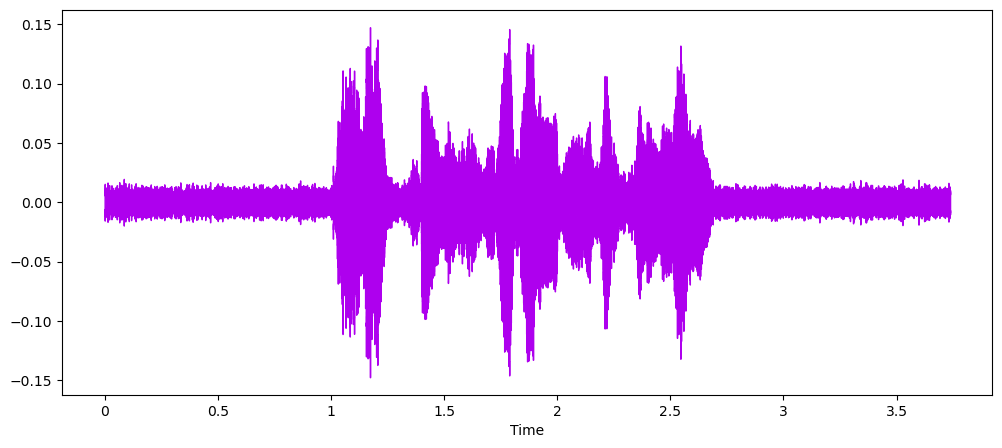

In [31]:
noised_data = add_noise(data)
plt.figure(figsize = (12, 5))
librosa.display.waveshow(y = noised_data, sr = sr, color = '#AE00EE')
IPython.display.Audio(noised_data, rate = sr)

### Stretched Audio

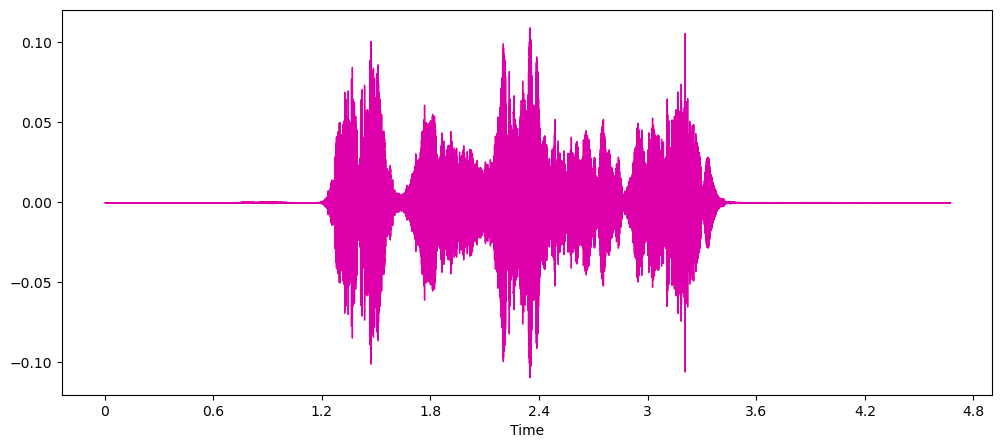

In [32]:
stretched_data = stretching(data)
plt.figure(figsize = (12,5))
librosa.display.waveshow(y = stretched_data, sr = sr,color='#DD00AA')
IPython.display.Audio(stretched_data,rate = sr)

### Shifted Audio

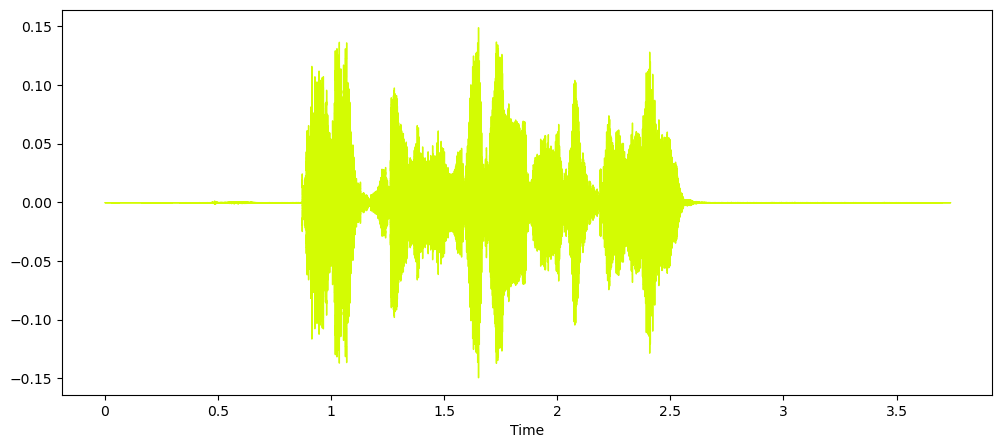

In [33]:
shifted_data = shifting(data)
plt.figure(figsize = (12, 5))
librosa.display.waveshow(y = shifted_data, sr = sr, color = '#d3fc03')
IPython.display.Audio(shifted_data, rate = sr)

### Pitched Audio

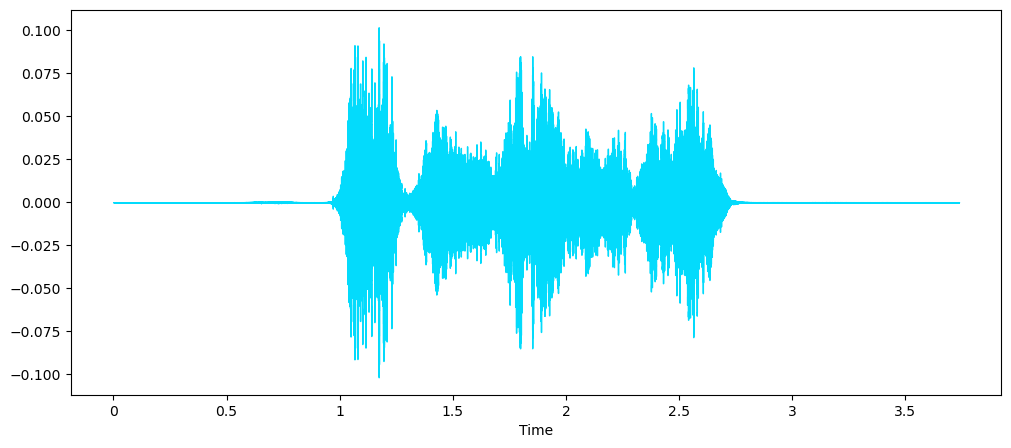

In [34]:
pitched_data = pitching(data, sr)
plt.figure(figsize = (12,5))
librosa.display.waveshow(y = pitched_data, sr = sr, color = '#03dbfc')
IPython.display.Audio(pitched_data, rate = sr)

## Feature Extraction

In [35]:
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length = frame_length, hop_length = hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length = 2048, hop_length = 512):
    rmse = librosa.feature.rms(y = data, frame_length = frame_length, hop_length = hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length = 2048, hop_length = 512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y = data, sr = sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr, frame_length = 2048, hop_length = 512):
    result = np.array([])
    result = np.hstack((result, zcr(data, frame_length, hop_length), rmse(data, frame_length, hop_length), mfcc(data, sr, frame_length, hop_length)))
    return result

def get_features(path, duration = 2.5, offset = 0.6):
    data, sr = librosa.load(path, duration = duration, offset = offset)
    aud = extract_features(data, sr)
    audio = np.array(aud)
    
    noised_audio = add_noise(data, random = True)
    aud2 = extract_features(noised_audio, sr)
    audio = np.vstack((audio, aud2))
    
    pitched_audio = pitching(data, sr, random = True)
    aud3 = extract_features(pitched_audio, sr)
    audio = np.vstack((audio, aud3))
    
    pitched_audio1 = pitching(data, sr, random = True)
    pitched_noised_audio = add_noise(pitched_audio1, random = True)
    aud4 = extract_features(pitched_noised_audio, sr)
    audio = np.vstack((audio, aud4))
    
    return audio

## Data Processing

In [36]:
X, Y = [], []

for path, emotion, index in zip(main_df.File_Path, main_df.Emotion, range(main_df.File_Path.shape[0])):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
7500 audio has been processed
8000 audio has been processed
8500 audio has been processed
9000 audio has been processed
9500 audio has been processed
10000 audio has been processed
10500 audio has been processed
11000 audio has been processed
11500 audio has been processed
12000 audio has been processed
Done


In [37]:
processed_data_path = './processed_data.csv'

In [38]:
extract = pd.DataFrame(X)
extract['Emotion'] = Y
extract.to_csv(processed_data_path, index = False)
extract.head()

0         1         2         3         4         5         6  \
0  0.122070  0.187988  0.235840  0.249512  0.249512  0.245605  0.237305   
1  0.122070  0.190430  0.243652  0.262207  0.266113  0.263184  0.252930   
2  0.115234  0.163574  0.210449  0.229492  0.236328  0.251465  0.229980   
3  0.119141  0.172363  0.218262  0.246094  0.248047  0.261719  0.241699   
4  0.016113  0.021484  0.029297  0.030762  0.033691  0.036133  0.038574   

          7         8         9  ...  2367  2368  2369  2370  2371  2372  \
0  0.183594  0.124512  0.073730  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.190430  0.135254  0.081543  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2  0.169434  0.117188  0.064941  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3  0.171875  0.122070  0.066895  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4  0.046875  0.054688  0.062500  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2373  2374  2375  Emotion  
0   NaN   NaN   NaN  disgust  
1   NaN   NaN   NaN  disgust  
2   NaN   NaN   NaN  disgust  
3   NaN   NaN   NaN  disgust  
4   NaN   NaN   NaN    happy  

[5 rows x 2377 columns]

## Including Analysed Audio Features

In [39]:
raw_df = pd.read_csv(processed_data_path)
raw_df.shape

(48648, 2377)

In [40]:
raw_df = raw_df.fillna(0)
print(raw_df.isna().any())
raw_df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


(48648, 2377)

In [41]:
raw_df.head()

0         1         2         3         4         5         6  \
0  0.122070  0.187988  0.235840  0.249512  0.249512  0.245605  0.237305   
1  0.122070  0.190430  0.243652  0.262207  0.266113  0.263184  0.252930   
2  0.115234  0.163574  0.210449  0.229492  0.236328  0.251465  0.229980   
3  0.119141  0.172363  0.218262  0.246094  0.248047  0.261719  0.241699   
4  0.016113  0.021484  0.029297  0.030762  0.033691  0.036133  0.038574   

          7         8         9  ...  2367  2368  2369  2370  2371  2372  \
0  0.183594  0.124512  0.073730  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.190430  0.135254  0.081543  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.169434  0.117188  0.064941  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.171875  0.122070  0.066895  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.046875  0.054688  0.062500  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   2373  2374  2375  Emotion  
0   0.0   0.0   0.0  disgust  
1   0.0   0.0   0.0  disgust  
2   0.0   0.0   0.0  disgust  
3   0.0   0.0   0.0  disgust  
4   0.0   0.0   0.0    happy  

[5 rows x 2377 columns]

## Processing Analysed Data for Training

In [42]:
X = raw_df.drop(labels = 'Emotion', axis = 1)
Y = raw_df['Emotion']

In [43]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Train Test and Validation Splitting

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38918, 2376), (9730, 2376), (38918, 7), (9730, 7))

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.1, shuffle = True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (3892, 2376), (35026, 7), (3892, 7))

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [47]:
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)
X_val = np.expand_dims(X_val, axis = 2)

## Tuning for Training

In [48]:
early_stop = EarlyStopping(monitor = 'val_acc', mode = 'auto', patience = 5, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [49]:
EPOCH = 50
BATCH_SIZE = 64

## Model Training

In [52]:
model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu', input_shape = (X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'),
    L.Conv1D(512, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'),
    L.Conv1D(256, kernel_size = 5, strides = 1,padding = 'same', activation = 'relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'),
    L.Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size = 5, strides = 2, padding = 'same'),
    L.Conv1D(128, kernel_size = 3,strides = 1, padding = 'same', activation = 'relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size = 3, strides = 2, padding = 'same'),
    L.Flatten(),
    L.Dense(512, activation = 'relu'),
    L.BatchNormalization(),
    L.Dense(7, activation = 'softmax')
])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2376, 512)         3072      
                                                                 
 batch_normalization_6 (Batc  (None, 2376, 512)        2048      
 hNormalization)                                                 
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1188, 512)        0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_7 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                      

In [53]:
history = model.fit(X_train, y_train, epochs = EPOCH, validation_data = (X_val, y_val), batch_size = BATCH_SIZE, callbacks = [early_stop, lr_reduction])

Epoch 1/50
548/548 [==============================] - 109s 172ms/step - loss: 1.3949 - accuracy: 0.4671 - val_loss: 1.3231 - val_accuracy: 0.4774 - lr: 0.0010
Epoch 2/50
548/548 [==============================] - 91s 166ms/step - loss: 1.1054 - accuracy: 0.5669 - val_loss: 1.1416 - val_accuracy: 0.5678 - lr: 0.0010
Epoch 3/50
548/548 [==============================] - 91s 166ms/step - loss: 0.9746 - accuracy: 0.6242 - val_loss: 1.1038 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 4/50
548/548 [==============================] - 91s 166ms/step - loss: 0.8566 - accuracy: 0.6761 - val_loss: 1.0571 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 5/50
548/548 [==============================] - 91s 166ms/step - loss: 0.7352 - accuracy: 0.7243 - val_loss: 0.8012 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 6/50
548/548 [==============================] - 91s 165ms/step - loss: 0.5738 - accuracy: 0.7898 - val_loss: 1.0173 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 7/50
548/548 [==============================]

## Drawing Charts

### Accuracy Charts

In [54]:
fig = px.line(history.history, y = ['accuracy','val_accuracy'],
           labels = {'index': 'epoch','value': 'accuracy'},
           title = f'According to the epoch accuracy and validation accuracy chart for the model')

fig.show()

### Loss Charts

In [55]:
fig = px.line(history.history, y = ['loss','val_loss'],
           labels = {'index': 'epoch','value': 'loss'},
           title = f'According to the epoch loss and validation loss chart for the model')

fig.show()

## Testing Model

In [56]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

305/305 [==============================] - 7s 21ms/step


array([3, 3, 0, ..., 4, 4, 3])

In [57]:
y_check = np.argmax(y_test, axis=1)
y_check

array([3, 3, 0, ..., 4, 4, 3])

In [58]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.2625623643398285
Test Accuracy: 0.9422404766082764


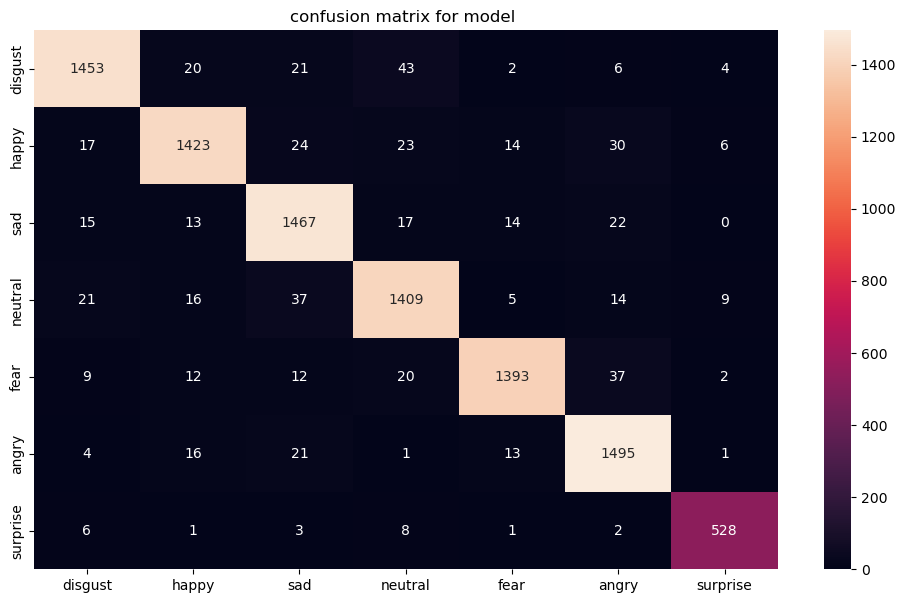

In [59]:
conf = confusion_matrix(y_check,y_pred)
cm = pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [60]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

     disgust       0.95      0.94      0.95      1549
       happy       0.95      0.93      0.94      1537
         sad       0.93      0.95      0.94      1548
     neutral       0.93      0.93      0.93      1511
        fear       0.97      0.94      0.95      1485
       angry       0.93      0.96      0.95      1551
    surprise       0.96      0.96      0.96       549

    accuracy                           0.94      9730
   macro avg       0.94      0.94      0.94      9730
weighted avg       0.94      0.94      0.94      9730



In [61]:
model_path = "./res_model.h5"

model.save(model_path)